In [78]:
import torch, torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset 

import matplotlib.pyplot as plt

# INPUT ENCODER

In [79]:
class per_ele_decoder(nn.Module):
    def __init__(self, in_dim, hidden_dim):
        super().__init__()
        self.phi = nn.Sequential(
            nn.Linear(in_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim)
        )

    def forward(self, x):
        # x: [B, N, D]
        out = self.phi(x)  # [B, N, H]
        return out
    
    

# MODIFIED CROSS-ATTENTION FOR SLOTS

In [80]:
class slot_attn(nn.Module):
    def __init__(self, num_slots, slot_dim, iters , input_dim=128, mlp_hidden_dim=256, epsilon=1e-8):
        super().__init__()
        self.num_slots = num_slots
        self.slot_dim = slot_dim
        self.epsilon = epsilon
        self.iters = iters

        self.slots_mu = nn.Parameter(torch.randn(1, num_slots, slot_dim))
        self.slots_logsigma = nn.Parameter(torch.zeros(1, num_slots, slot_dim))

        self.project_q = nn.Linear(slot_dim, slot_dim, bias=False)
        self.project_k = nn.Linear(slot_dim, slot_dim, bias=False)
        self.project_v = nn.Linear(slot_dim, slot_dim, bias=False)

        self.gru = nn.GRUCell(slot_dim, slot_dim)

        self.mlp = nn.Sequential(
            nn.Linear(slot_dim, mlp_hidden_dim),
            nn.ReLU(),
            nn.Linear(mlp_hidden_dim, slot_dim)
        )

        self.norm_input = nn.LayerNorm(slot_dim)
        self.norm_slots = nn.LayerNorm(slot_dim)
        self.norm_mlp = nn.LayerNorm(slot_dim)
    
    def forward(self, inputs, input_mask=None, return_attn=True):
        B, n, _ = inputs.shape
        inputs = self.norm_input(inputs)
        
        mu = self.slots_mu.expand(B, -1, -1)
        sigma  = (0.5 * self.slots_logsigma).exp().expand(B, -1, -1)
        slots = mu + 2.0 * sigma * torch.randn_like(mu)

        k = self.project_k(inputs)
        v = self.project_v(inputs)

        if input_mask is None:
            attn_mask = None
        else:
            attn_mask = input_mask
        attn_list = []
            
        for _ in range(self.iters):
            slots_prev = slots
            slots_norm = self.norm_slots(slots)
            q = self.project_q(slots_norm)

            attn_logits = torch.einsum('bqd,bkd->bqk', q, k) / (self.slot_dim ** 0.5)

            if attn_mask is not None:
                mask = attn_mask.unsqueeze(1)
                attn_logits = attn_logits.masked_fill(~mask, float('-inf'))
            attn = F.softmax(attn_logits, dim=-1) + self.epsilon
            updates = torch.einsum('bqk,bkd->bqd', attn, v)


            slots_flat = slots.view(B*self.num_slots, self.slot_dim)
            updates_flat = updates.view(B*self.num_slots, self.slot_dim)
            slots_updated = self.gru(updates_flat, slots_flat)
            slots = slots_updated.view(B, self.num_slots, self.slot_dim)

            slots = slots + self.mlp(self.norm_mlp(slots))
            slots = slots + 0.01*torch.randn_like(slots)
            
            if return_attn:
                attn_list.append(attn)
        if return_attn:
            return slots, attn_list
        else:
            return slots


# SLOT DECODER

In [81]:
class slot_decoder(nn.Module):
    def __init__(self, slot_dim, element_dim):
        super().__init__()
        self.to_element = nn.Sequential(
            nn.Linear(slot_dim, slot_dim),
            nn.ReLU(),
            nn.Linear(slot_dim, element_dim)
        )

    def forward(self, slots):
        return self.to_element(slots)

# COMPLETE S2S

In [82]:
class slot_s2s(nn.Module):
    def __init__(self, in_dim, enc_hid, slot_dim, num_slots, slot_iters, element_dim):
        super().__init__()
        self.encoder = per_ele_decoder(in_dim, enc_hid)
        self.cross_proj = nn.Linear(enc_hid, slot_dim) #project encoder output to slot dimension
        self.slot_attn = slot_attn(num_slots, slot_dim, slot_iters, enc_hid, mlp_hidden_dim=slot_dim*2)
        self.decoder = slot_decoder(slot_dim, element_dim)

    def forward(self, x, x_mask=None):
        H = self.encoder(x)  # [B, N, enc_hid]
        H_proj = self.cross_proj(H)  # [B, N, slot_dim]
        slots, attn = self.slot_attn(H_proj, x_mask, return_attn=True)  # [B, num_slots, slot_dim]
        out = self.decoder(slots)  # [B, num_slots, element_dim]
        return out, attn
    



# SYNTHETIC DATA

In [83]:
class synthetic_set(Dataset):
    def __init__(self, num_samples, min_len, max_len, elem_dim):
        self.data = []
        for _ in range(num_samples):
            n = int(torch.randint(int(min_len), int(max_len)+1, (1,)).item())
            m = int(torch.randint(int(min_len), int(max_len)+1, (1,)).item())
            A = torch.randn(n, elem_dim)
            B = (torch.randn(m, elem_dim)*0.05 + A[torch.randint(0, n, (m,), dtype=torch.long), :])
            self.data.append((A,B))

    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        return self.data[index]
    

def collate_fn(batch, num_slots):
    As, Bs = zip(*batch)
    Bsize = num_slots
    D = As[0].shape[1]
    max_n = max([a.shape[0] for a in As])
    A_padded = torch.zeros(len(batch), max_n, D)
    A_mask = torch.zeros(len(batch), max_n, dtype=torch.bool)
    B_padded = torch.zeros(len(batch), Bsize, D)
    B_mask = torch.zeros(len(batch), Bsize, dtype=torch.bool)

    for i, (a, b) in enumerate(zip(As, Bs)):
        n = a.shape[0]
        m = b.shape[0]
        num_b = min(m, Bsize)
        A_padded[i, :n, :] = a
        A_mask[i, :n] = 1
        B_padded[i, :num_b, :] = b[:num_b]
        B_mask[i, :num_b] = 1
    return A_padded, B_padded, A_mask, B_mask


# CHAMFER DISTANCE

In [84]:
def chamfer_loss(pred, target, pred_mask, target_mask):
    B, N, D = pred.shape
    
    diff = pred.unsqueeze(2) - target.unsqueeze(1)  # [B, N, M, D]
    dist = torch.sum(diff ** 2, dim=-1)  # [B, N, M]

    pred_mask = pred_mask.unsqueeze(2)  # [B, N, 1]
    target_mask = target_mask.unsqueeze(1)  # [B, 1, M
    valid = pred_mask & target_mask  # [B, N, M]

    dist_marked = dist.clone()
    dist_marked[~valid] = float('inf')

    min_pred = dist_marked.min(dim=2)[0]  # [B, N]
    min_target = dist_marked.min(dim=1)[0]  # [B, M]

    if pred_mask.any():
        loss_pred = min_pred[pred_mask.squeeze(2)].mean()
    else:
        loss_pred = torch.tensor(0.0, device=pred.device)

    if target_mask.any():
        loss_target = min_target[target_mask.squeeze(1)].mean()
    else:
        loss_target = torch.tensor(0.0, device=target.device)

    return loss_pred + loss_target

# TRAINING

In [85]:
def train_slot_s2s(num_epochs=20, batch_size=16, device=None):
    if device is None:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    in_dim = 100
    enc_hid = 128
    slot_dim = 128
    num_slots = 8
    iters = 3
    element_dim = 100

    dataset = synthetic_set(num_samples=2000, min_len=2, max_len=8, elem_dim=in_dim)
    dl = DataLoader(dataset, batch_size=batch_size, shuffle=True,
                    collate_fn=lambda b: collate_fn(b, num_slots=num_slots))

    model = slot_s2s(in_dim, enc_hid, slot_dim, num_slots, iters, element_dim).to(device)
    optimizer = optim.Adam(model.parameters(), lr=5e-4)

    for epoch in range(num_epochs):
        total = 0.0
        cnt = 0
        for A, B, A_mask, B_mask in dl:
            A = A.to(device)
            B = B.to(device)
            A_mask = A_mask.to(device)
            B_mask = B_mask.to(device)

            optimizer.zero_grad()
            B_hat, attn_list = model(A, x_mask=A_mask)  # [B, num_slots, element_dim]

            loss = chamfer_loss(B_hat, B, pred_mask=B_mask, target_mask=B_mask)
            loss.backward()
            optimizer.step()

            total += loss.item()
            cnt += 1

        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {total/cnt:.4f}")

    return model, attn_list

In [86]:
model, attn_list = train_slot_s2s(num_epochs=50, batch_size=16)

Epoch 1/50, Loss: 187.0514
Epoch 2/50, Loss: 181.7654
Epoch 3/50, Loss: 174.1998
Epoch 4/50, Loss: 167.7256
Epoch 5/50, Loss: 163.1321
Epoch 6/50, Loss: 159.5002
Epoch 7/50, Loss: 155.9368
Epoch 8/50, Loss: 152.5797
Epoch 9/50, Loss: 150.5480
Epoch 10/50, Loss: 148.3271
Epoch 11/50, Loss: 146.3140
Epoch 12/50, Loss: 144.5460
Epoch 13/50, Loss: 142.9698
Epoch 14/50, Loss: 142.1329
Epoch 15/50, Loss: 140.2866
Epoch 16/50, Loss: 138.2351
Epoch 17/50, Loss: 137.5438
Epoch 18/50, Loss: 136.0900
Epoch 19/50, Loss: 134.0786
Epoch 20/50, Loss: 133.3713
Epoch 21/50, Loss: 131.2974
Epoch 22/50, Loss: 129.0799
Epoch 23/50, Loss: 129.1169
Epoch 24/50, Loss: 128.4262
Epoch 25/50, Loss: 128.3999
Epoch 26/50, Loss: 125.7349
Epoch 27/50, Loss: 124.3104
Epoch 28/50, Loss: 123.2163
Epoch 29/50, Loss: 123.0633
Epoch 30/50, Loss: 122.7307
Epoch 31/50, Loss: 121.5929
Epoch 32/50, Loss: 120.2337
Epoch 33/50, Loss: 118.8382
Epoch 34/50, Loss: 118.3723
Epoch 35/50, Loss: 118.2497
Epoch 36/50, Loss: 118.4353
E

# VISUALIZE THE LEARNING

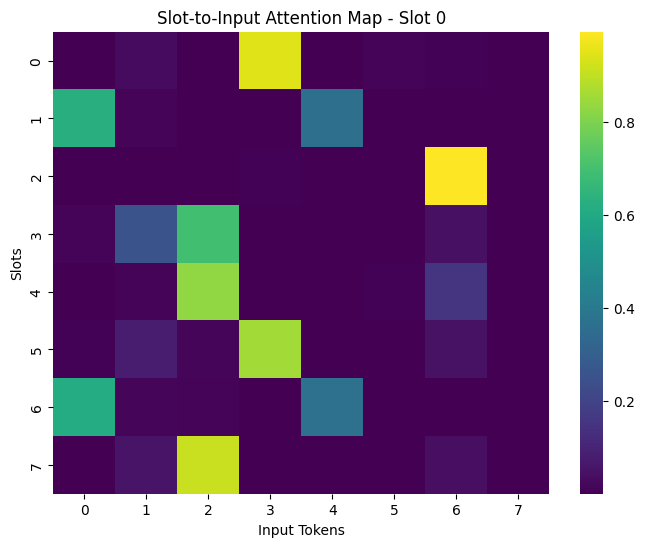

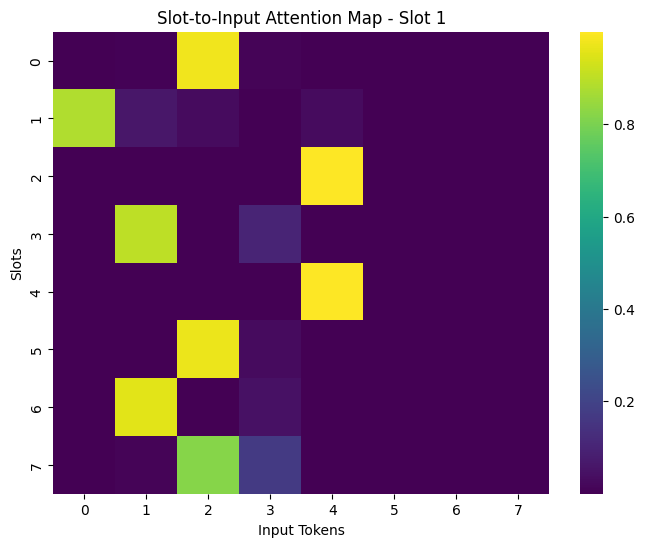

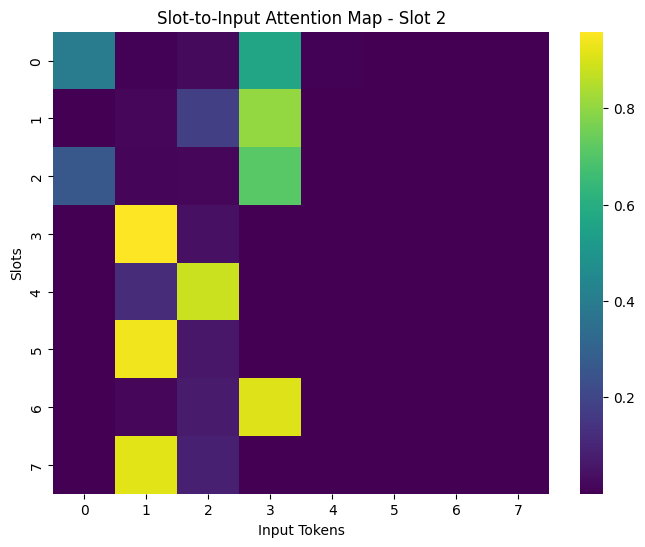

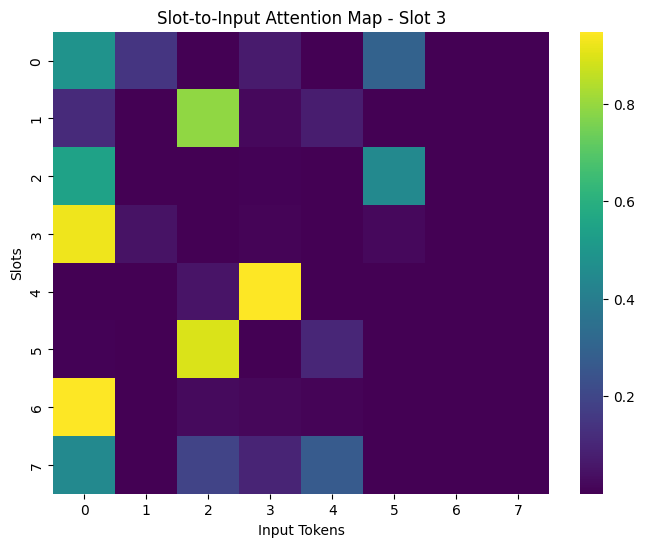

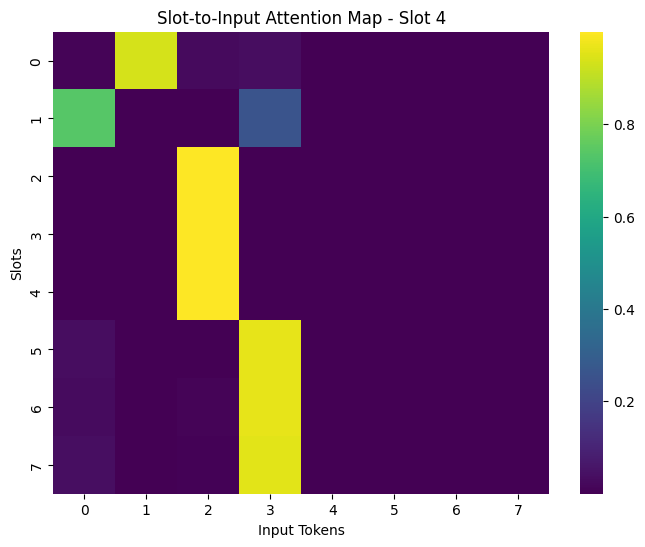

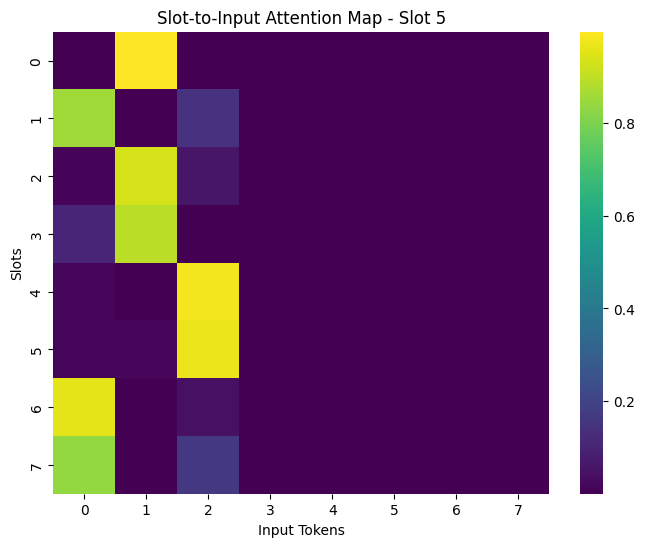

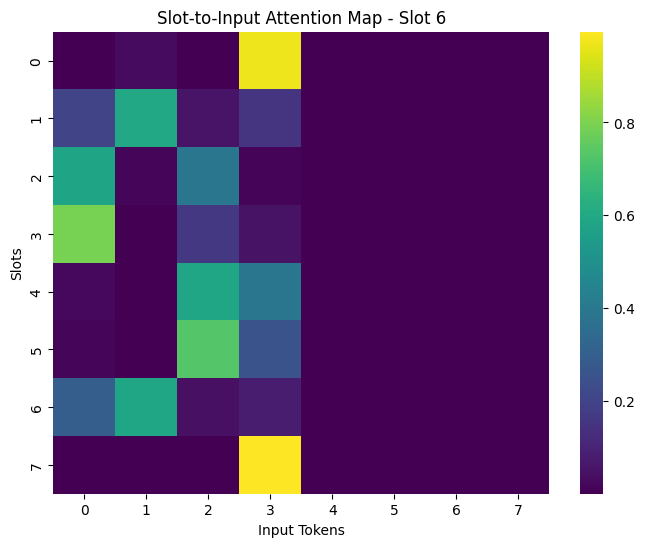

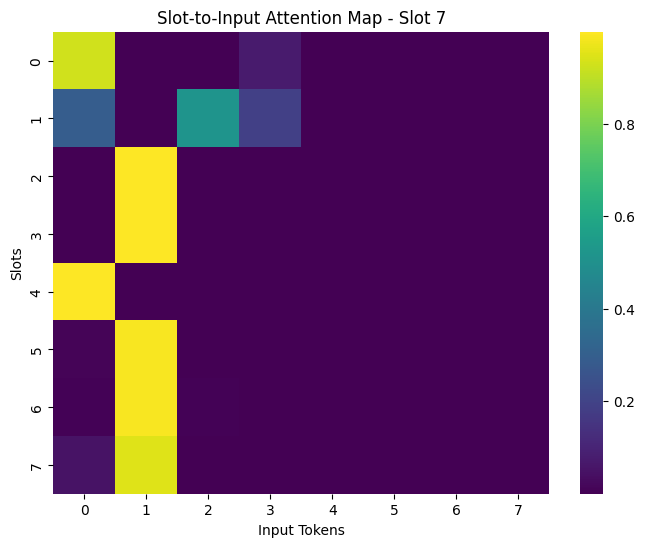

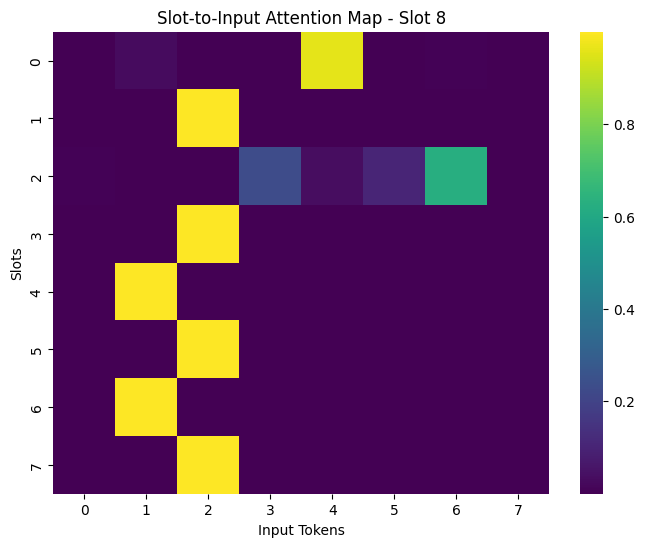

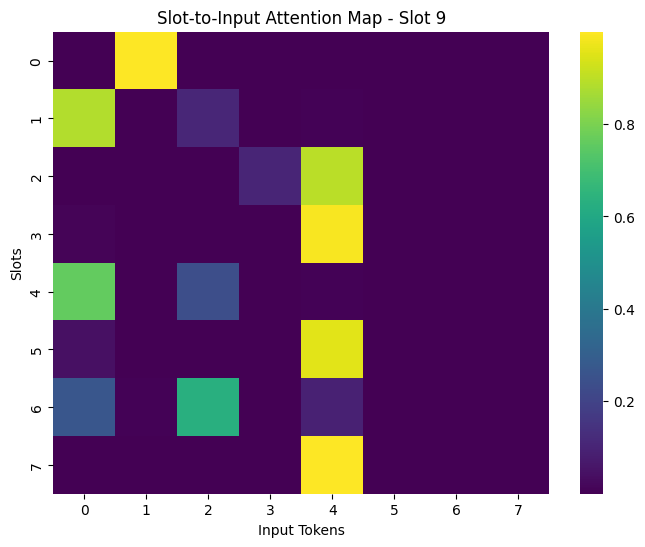

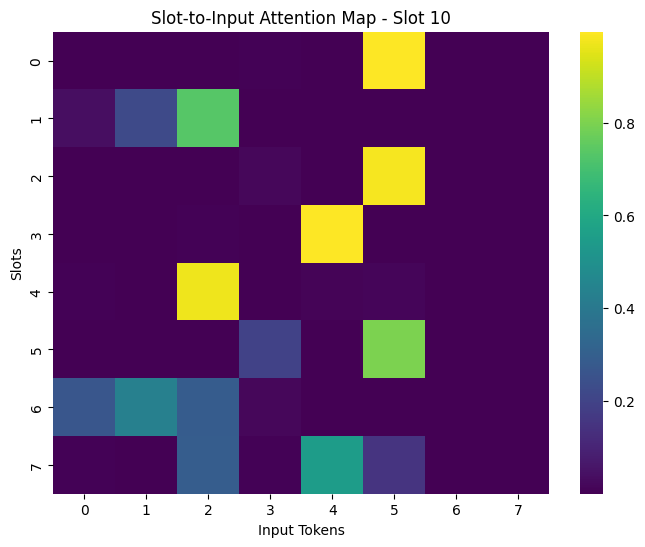

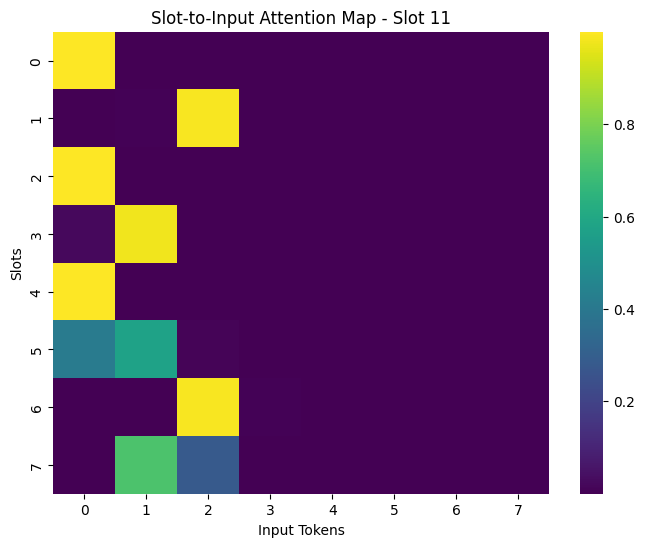

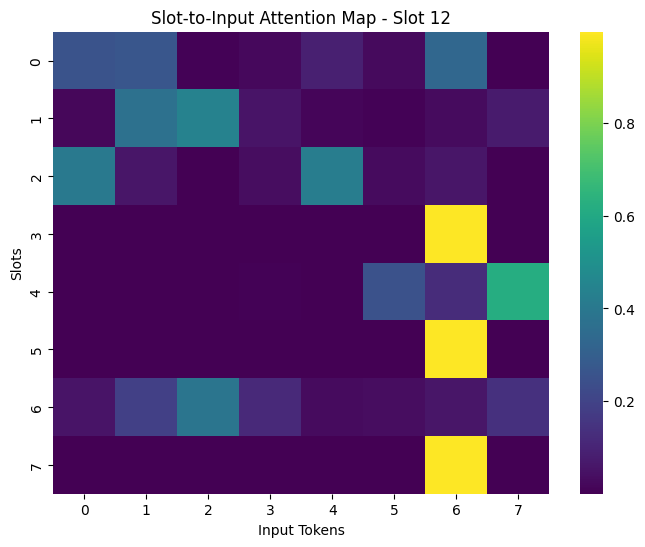

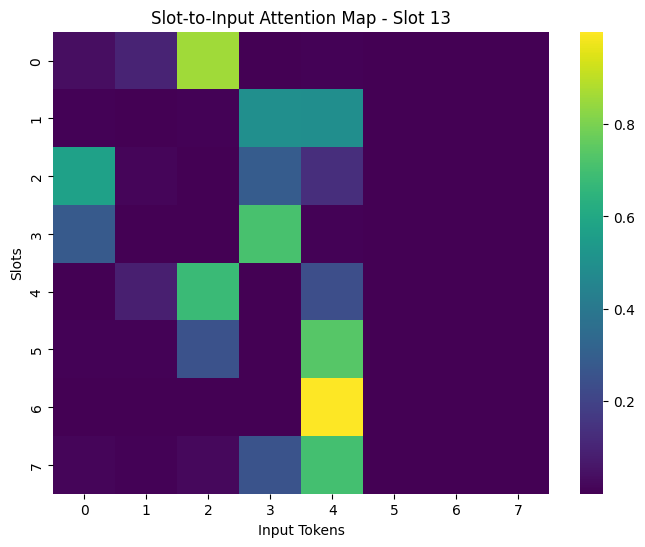

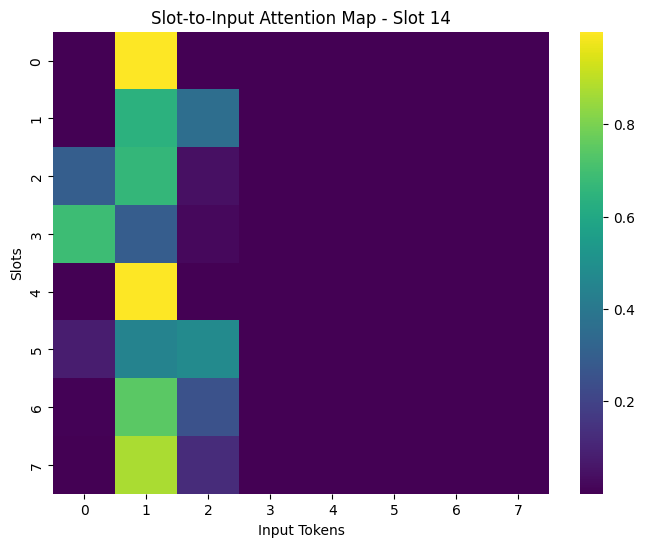

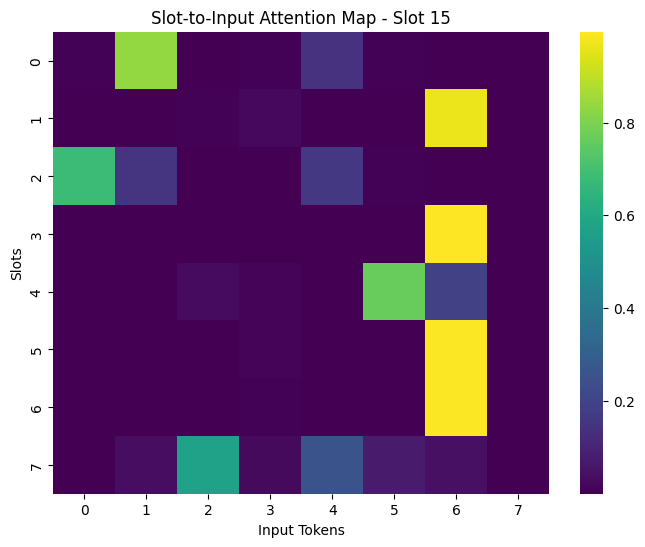

In [90]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

for i, attn_i in enumerate(attn_list[-1].squeeze().cpu().detach().numpy()):
    plt.figure(figsize=(8, 6))
    sns.heatmap(attn_i, cmap='viridis')
    plt.xlabel("Input Tokens")
    plt.ylabel("Slots")
    plt.title(f"Slot-to-Input Attention Map - Slot {i}")
    plt.show()

